Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split

# класс для kNN классификатора
from sklearn.neighbors import KNeighborsClassifier 

# метод для кросс-валидации данных
from sklearn.model_selection import cross_val_score 

# алгоритм разбиения выборки на группы(фолды)
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
# алгоритм разбиения выборки на стратифицированные группы(фолды)
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
%matplotlib inline


In [2]:
import numpy as np

# Класс узла дерева
class Node:
    # конструктор
    def __init__(self, predicted_class):
        # поле класса
        self.predicted_class = predicted_class
        # поле фичи
        self.feature_index = 0
        # предел
        self.threshold = 0
        # левый ребёнок
        self.left = None
        # правый ребёнок
        self.right = None


class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        # конструктор дерева
        self.max_depth = max_depth

    def fit(self, X, y):
        # помещаем количество классов [0; n-1]
        self.n_classes_ = len(set(y))
        # помещаем кол-во фичей
        self.n_features_ = X.shape[1]
        #строим дерево
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _best_split(self, X, y):
        # проверяем достаточно ли данных для разбиения (>=2)
        m = y.size
        if m <= 1:
            return None, None
        # считаем количество классов в текущем узле
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        # вычисление Джини для 
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        # best_idx - номер фичи для лучшего разбиения (None - если такого нет), best_thr - пороговое значение для разбиения
        best_idx, best_thr = None, None
        # проходим по всем фичам и пытаемся построить разбиение
        for idx in range(self.n_features_):
            #собираем пары порогов и классов для той или иной фичи
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            # определяем количество эл-тов того или иного класса
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            # получается m-i эл-тов справа и i эл-тов слева
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                # исключаем тот случай, когда бывают случаи с идентичными значениями для той или иной фичи
                if thresholds[i] == thresholds[i - 1]:
                    continue
                #Если нашли такую минимальную пару (Лучшей фичи и лучшего порога), то обновляем значения
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _grow_tree(self, X, y, depth=0):
        # определяем кол-во эл-тов для каждого класса
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        # предсказанный класс - класс с наиб. количеством элементов в нём
        predicted_class = np.argmax(num_samples_per_class)
        # записываем в ноду предсказанный класс
        node = Node(predicted_class=predicted_class)
        # если строить ещё можно (не ограничены глубиной)
        if depth < self.max_depth:
            # ищем лучшее разбиение 
            idx, thr = self._best_split(X, y)
            # если разбиение нашлось, то строим детей и вызываемся от них рекурсивно с глубиной++
            if idx is not None:
                # слева у нас всё то, что меньше порогового значения, а справа соотв. больше
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node
    
    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

# Загрузка датасета и  проверка загрузки

In [3]:
df = pd.read_csv('dataset_task6.csv')

In [4]:
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [6]:
df.describe(include=['O'])

,state,phone number,international plan,voice mail plan
count,3333,3333,3333,3333
unique,51,3333,2,2
top,WV,382-4657,no,no
freq,106,1,3010,2411


In [7]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

df['state'] = label_encoder.fit_transform(df['state'])
df['international plan'] = label_encoder.fit_transform(df['international plan'])
df['voice mail plan'] = label_encoder.fit_transform(df['voice mail plan'])
df['churn'] = label_encoder.fit_transform(df['churn'])
df.drop(["phone number"], axis = 1, inplace=True)

C:\Users\illus\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='churn', ylabel='count'>

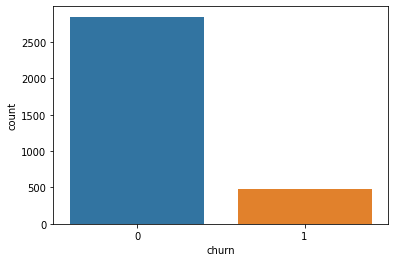

In [8]:
sns.countplot(df['churn'])

<AxesSubplot:>

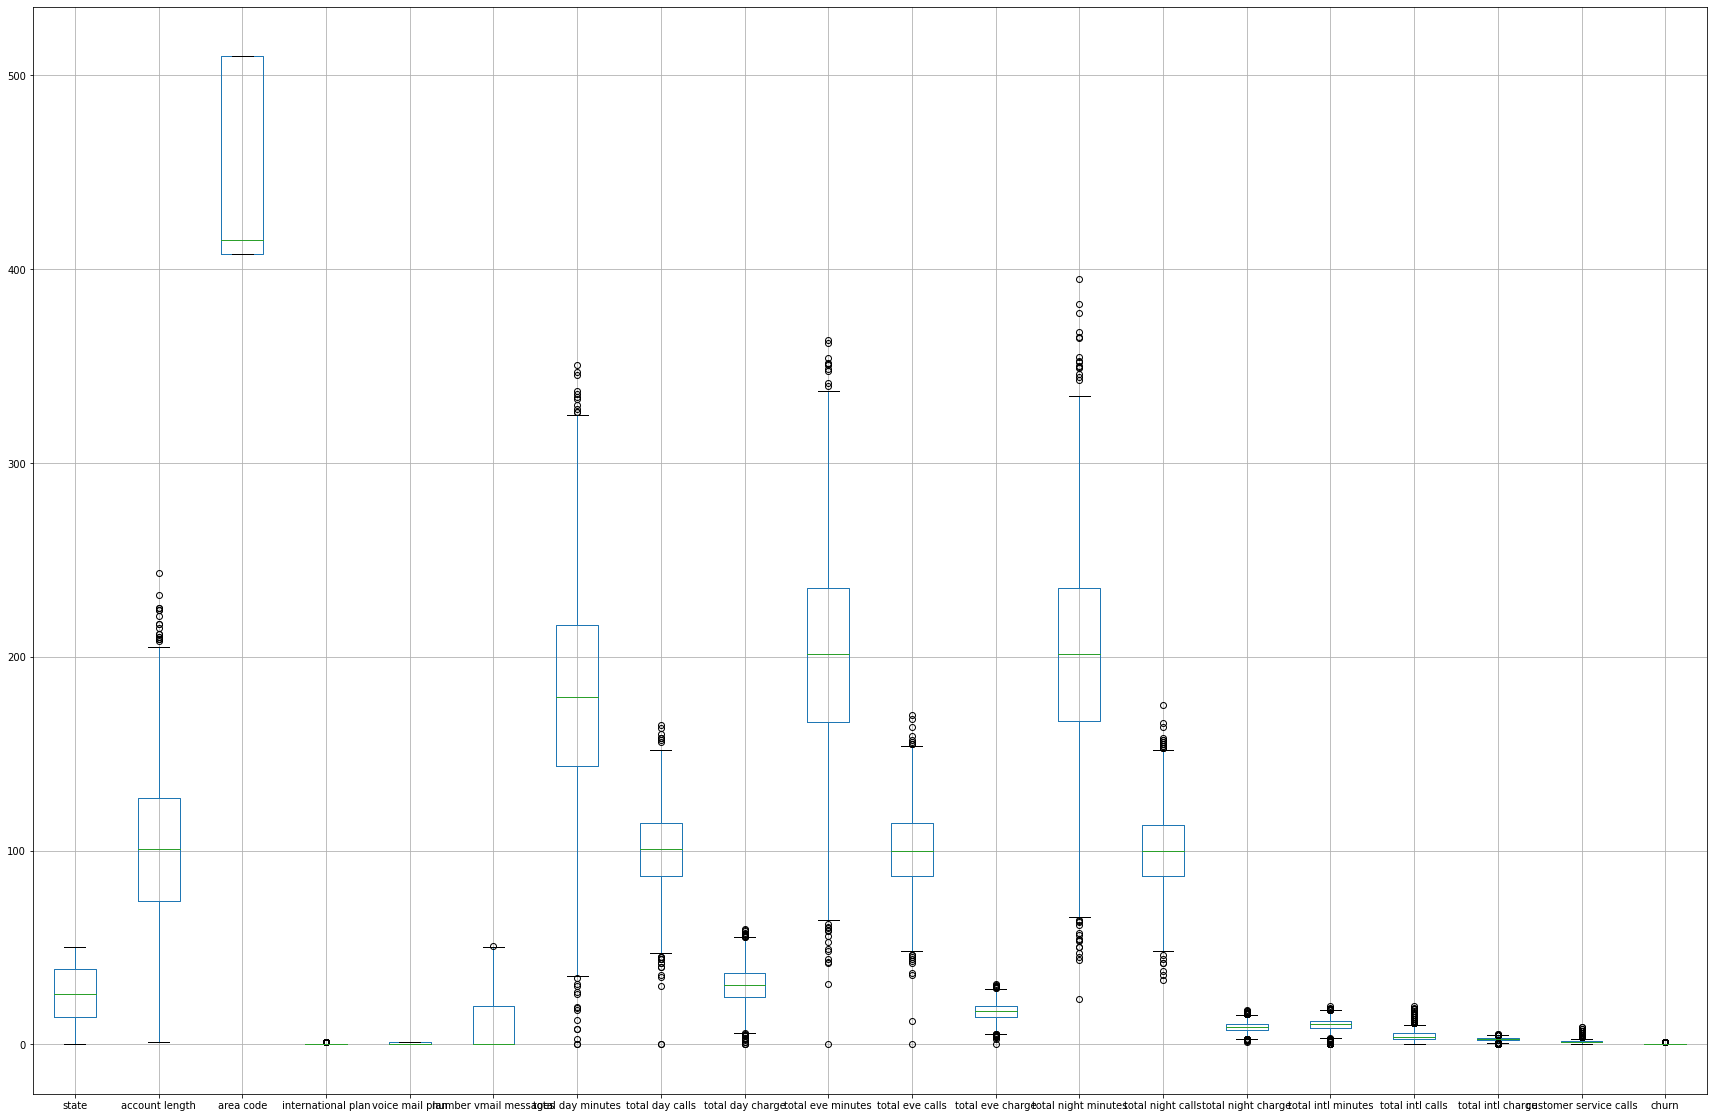

In [9]:
df.boxplot(figsize=(30, 20))

<AxesSubplot:>

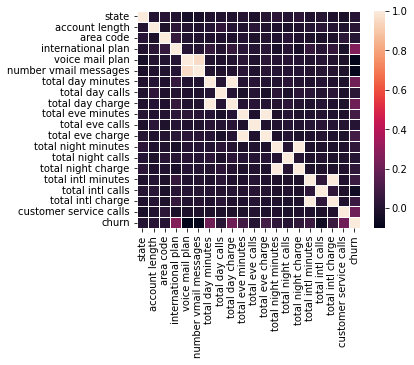

In [10]:
corr = df.corr()

fig = plt.figure(figsize=(5,4))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            linewidths=.75)

In [11]:
from sklearn.metrics import f1_score
X = df.iloc[:,0:19].values
y = df.iloc[:,19].values
for i in range (1, 6):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print(f1_score(y, y_pred))

0.3659942363112392
0.5560538116591929
0.547550432276657
0.6946564885496183
0.8171296296296297


In [12]:

from sklearn.ensemble import RandomForestClassifier
clf_temp_2 = sk.tree.DecisionTreeClassifier(max_depth=5)
clf_temp_2.fit(X,y)
y_pred_2 = clf_temp_2.predict(X)
print(f1_score(y, y_pred_2))

0.8171296296296297


In [13]:
random_forest = RandomForestClassifier()
random_forest.fit(X,y)
y_pred_forest = random_forest.predict(X)
print(f1_score(y, y_pred_forest))

1.0
